In [191]:
%pylab inline
import scipy as sp
import pandas as pd
autumn();

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [83]:
data = pd.read_csv('in.csv', index_col=0)
data.head(3)

,a,b,c,d,e
id,,,,,
1,7906633,20,130,0,483
2,NaN,NaN,70,NaN,152
3,19122621,642,20,13283,NaN


In [162]:
log_data = data.copy()
for c in log_data.columns:
    if c != 'd':
        log_data[c] = np.log(log_data[c] + 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(log_data.dropna())

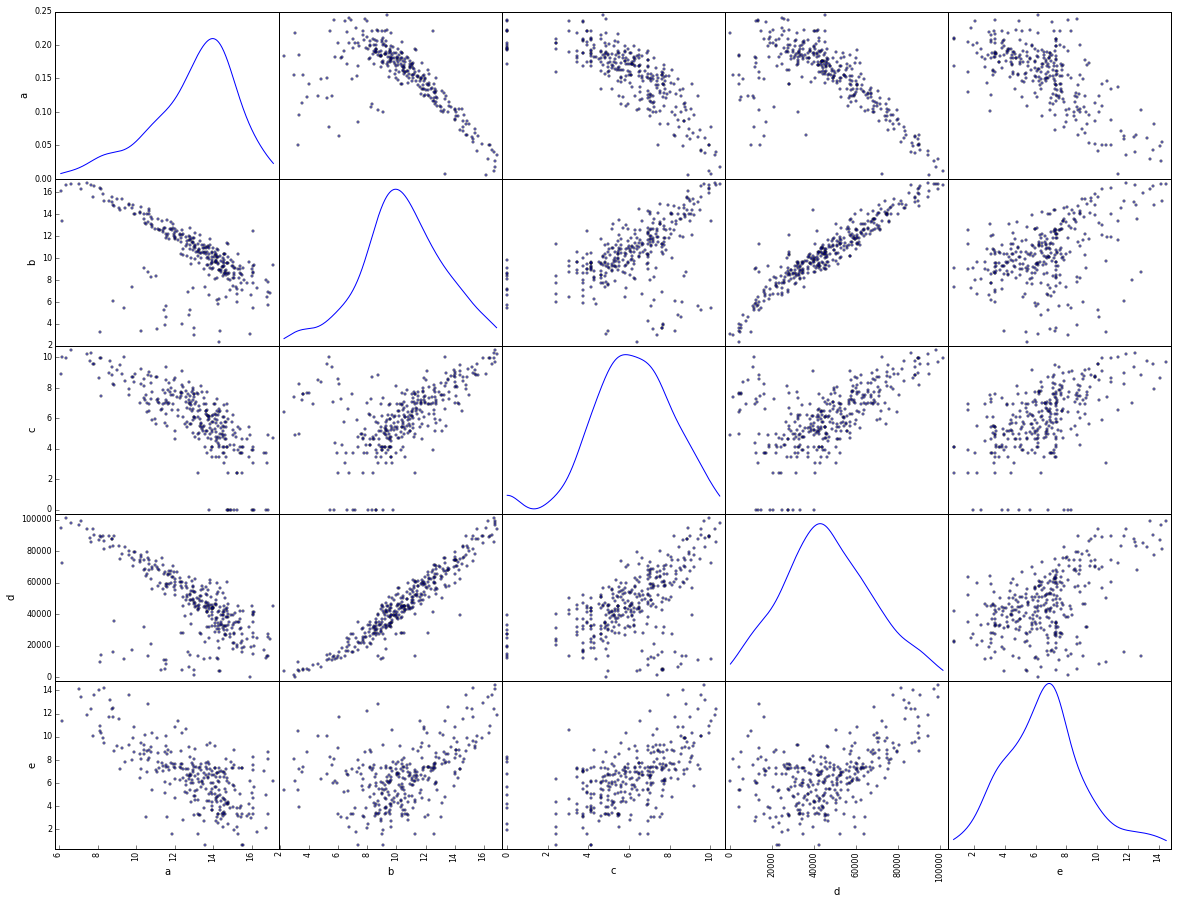

In [175]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(log_data, figsize=(20, 15), diagonal='kde');

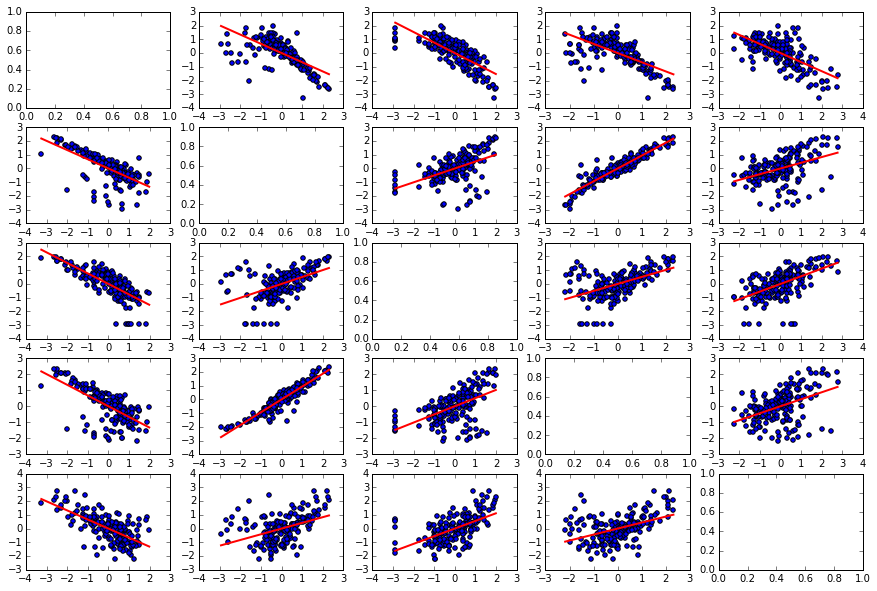

In [207]:
from sklearn.linear_model import LinearRegression
num_features = scaled_data.shape[1]
f, plots = plt.subplots(num_features, num_features)
for row in range(num_features):
    for column in range(num_features):
        if row != column:
            y = scaled_data[:, row]
            x = scaled_data[:, column, np.newaxis]
            f.set_size_inches(15, 10)
            current_plot = plots[row][column]
            current_plot.scatter(x, y)
            l = LinearRegression()
            l.fit(x, y)
            current_plot.plot((x.min(), x.max()),
                              (x.min() * l.coef_ + l.intercept_,
                               x.max() * l.coef_ + l.intercept_),
                              "r-",
                              linewidth=2)

In [208]:
data[np.isnan(data.b) & np.isnan(data.d)]

,a,b,c,d,e
id,,,,,
2,NaN,NaN,70,NaN,152
26,7630769,NaN,230,NaN,28
31,193603,NaN,475,NaN,NaN
32,545039,NaN,10,NaN,4
203,406849,NaN,650,NaN,2253


0    179
1    187
2     65
3      8
dtype: int64

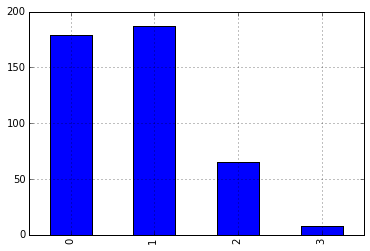

In [84]:
missing_values = data.isnull().sum(axis=1)
missing_groups = missing_values.groupby(missing_values.values).size()
missing_groups.plot(kind='bar')
missing_groups

In [176]:
data[data.isnull().sum(axis=1) == 3]

,a,b,c,d,e
id,,,,,
2,NaN,NaN,70,NaN,152
31,193603,NaN,475,NaN,NaN
128,NaN,NaN,60,32516,NaN
157,6986,NaN,NaN,35969,NaN
213,NaN,NaN,325,53715,NaN
252,NaN,NaN,NaN,59587,8
343,NaN,NaN,NaN,41941,780
398,NaN,NaN,NaN,35472,132


In [85]:
data.describe()

,a,b,c,d,e
count,350.000000,375.000000,368.000000,404.000000,357.000000
mean,1931520.328571,872379.480000,2188.179348,46544.349010,35593.725490
std,3706373.503441,2957194.665734,4620.451613,21411.213027,181819.857097
min,444.000000,9.000000,0.000000,0.000000,1.000000
25%,111216.250000,6415.500000,130.000000,32090.250000,132.000000
50%,632400.000000,32700.000000,475.000000,44939.500000,784.000000
75%,1970495.750000,222177.500000,1800.000000,60289.250000,2516.000000
max,27057179.000000,21245399.000000,35000.000000,101295.000000,1918620.000000


In [86]:
extended_data = data.copy()
for c in extended_data.columns:
    extended_data["log_{}".format(c)] = np.log(1 + data[c])

In [87]:
data.shape

(439, 5)

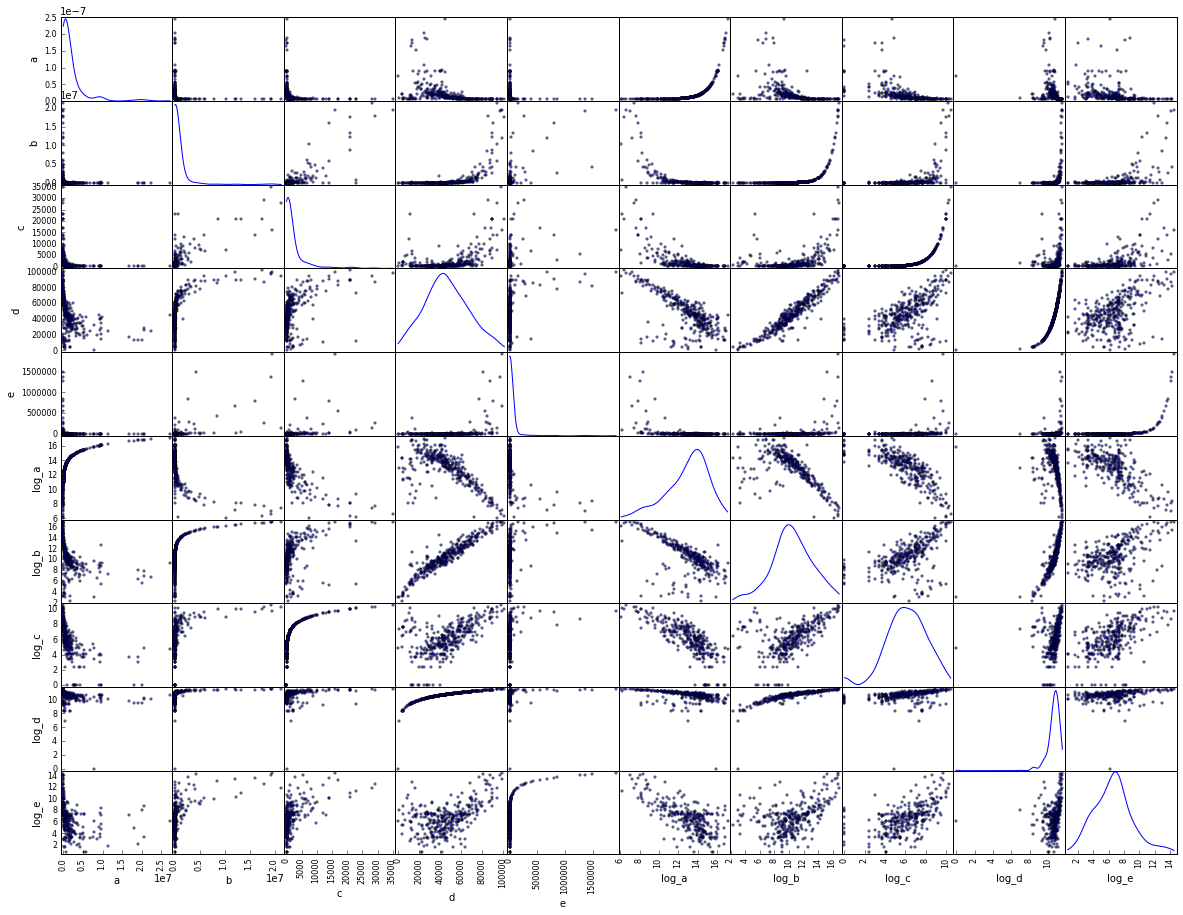

In [88]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(extended_data, figsize=(20, 15), diagonal='kde');

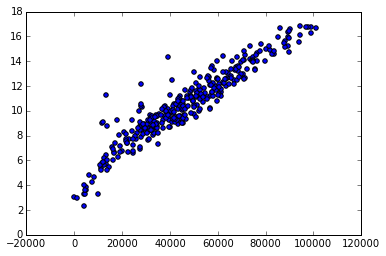

In [89]:
scatter(extended_data.d, extended_data.log_b);

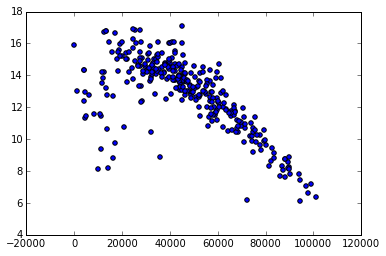

In [90]:
scatter(extended_data.d, extended_data.log_a);

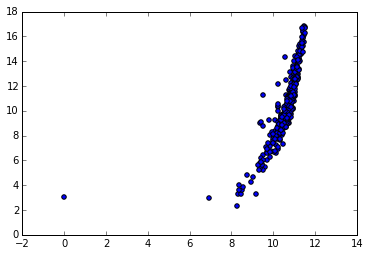

In [91]:
scatter(extended_data.log_d, extended_data.log_b);

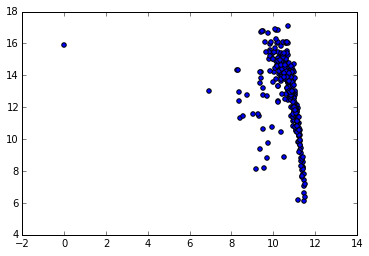

In [92]:
scatter(extended_data.log_d, extended_data.log_a);

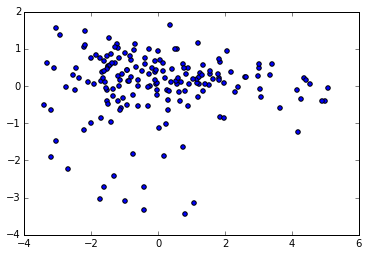

In [210]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(scaled_data)
scatter(*(data_2d.T));

# Solution:

In [360]:
p = data.dropna().iloc[13]
p

a    4355929
b       8161
c         50
d      34743
e          4
Name: 45, dtype: float64

In [361]:
p[0] = np.NaN
p[1] = np.NaN
p[2] = np.NaN
# p[3] = np.NaN
# p[4] = np.NaN
p

a      NaN
b      NaN
c      NaN
d    34743
e        4
Name: 45, dtype: float64

-1.70628503e+02  -4.40527517e+00   1.98912198e+02  -2.60563381e-02
   2.22166515e+02

In [382]:
pca = PCA(n_components=5)
pca.fit(scaled_data)
point_mask = np.array([1,1,1,0,1], dtype=bool)

def transform_log(X):
    return X * ~point_mask + np.log1p(X * point_mask)

def inverse_transform_log(X):
    return X * ~point_mask + np.expm1(X * point_mask)

def fill(point):
    log_point = transform_log(np.nan_to_num(point))
    X = scaler.transform(log_point)
    mask = ~np.isnan(point).values
    X = X * mask
    num_components = mask.sum()
    V = pca.components_[:num_components]
    K = np.linalg.lstsq((V * mask).T, X.T)[0].T
    log_predict = scaler.inverse_transform(X + (~mask * (K.dot(V))))
    return inverse_transform_log(log_predict)
[p, fill(p)]

[a      NaN
 b      NaN
 c      NaN
 d    34743
 e        4
 Name: 45, dtype: float64,
 array([  1.37614070e+07,   9.02694104e+03,   9.57367966e+00,
          3.47430000e+04,   4.00000000e+00])]

In [477]:
class Filler:
    def __init__(self):
        self._pca = PCA()
        self._scaler = StandardScaler()
        # self._mask = np.array([1,1,1,0,1], dtype=bool)
        self._mask = np.array([0,0,0,0,0], dtype=bool)
    def _log_transform(self, X):
        return X * ~self._mask + np.log1p(X * self._mask)
    def _inverse_log_transform(self, X):
        return X * ~self._mask + np.expm1(X * self._mask)
    def transform(self, X):
        return self._scaler.transform(self._log_transform(X))
    def inverse_transform(self, X):
        return self._inverse_log_transform(self._scaler.inverse_transform(X))
    def fit(self, X):
        self._pca.fit(self._scaler.fit_transform(self._log_transform(X)))
    def predict(self, point):
        mask = ~np.isnan(point)
        n_components = mask.sum()
        if n_components == mask.shape[0]:
            return point
        filled_point = self.transform(np.nan_to_num(point))
        filled_point[~mask] = 0
        basis = self._pca.components_[:n_components]
        coefficients = np.linalg.lstsq((basis * mask).T, filled_point.T)[0].T
        prediction = filled_point + (~mask * (coefficients.dot(basis)))
        return self.inverse_transform(prediction)

def get_test_data(data, threshold):
    result = data.copy().astype(float)
    result.iloc[np.random.sample(result.shape) < threshold] = np.NaN
    return result

def test_filler(filler, data, threshold):
    answer = data
    test_data = get_test_data(data, threshold)
    filler_answer = np.zeros(answer.shape)
    for idx, point in enumerate(test_data.values):
        filler_answer[idx] = filler.predict(point)
        print(filler_answer[idx])
    return (filler.transform(filler_answer - answer)**2).mean()
    
f = Filler()
train_data = data.dropna()
p = data.ix[2]
f.fit(train_data)
test_filler(f, train_data, threshold=0.2)

[  7.90663300e+06   2.00000000e+01   1.30000000e+02   0.00000000e+00
   7.86726339e+04]
[  9.56252000e+05   7.46000000e+02   0.00000000e+00   2.47760000e+04
   8.84000000e+02]
[ 101783.          144043.            1300.           46507.60562213
   18125.82985369]
[  2.06646130e+07   9.99782873e+06   1.33277428e+04   2.53920000e+04
   3.60721043e+05]
[  2.17483700e+06   6.53500000e+03   1.00000000e+02   2.74480000e+04
   2.35000000e+02]
[  7.79636900e+06   1.53000000e+04   3.00000000e+01   3.18180000e+04
   6.50000000e+01]
[ 2641372.             3175.                0.            32927.
   120214.27737604]
[  2.61681300e+06   7.91230000e+04   1.00000000e+01   8.63562501e+04
   8.00000000e+01]
[  1.11753600e+06   1.38210000e+04   6.00000000e+01   3.22720000e+04
   3.70000000e+01]
[  9.66928053e+06   1.04720000e+04   6.00000000e+01   2.05946482e+04
   4.60000000e+01]
[ 547348.           40330.            1190.28492512   46029.68829436
     581.        ]
[  7.55644000e+05   7.91500000e+03 

3.3418480869279761

In [428]:
default_logs = 4.8586939141835435e+51
no_logs = 3.323284235257788

In [420]:
[i for i in train_data.values]

[array([  7.90663300e+06,   2.00000000e+01,   1.30000000e+02,
          0.00000000e+00,   4.83000000e+02]),
 array([  9.56252000e+05,   7.46000000e+02,   0.00000000e+00,
          2.47760000e+04,   8.84000000e+02]),
 array([ 101783.,  144043.,    1300.,   59036.,    1599.]),
 array([  2.06646130e+07,   2.54400000e+03,   1.30000000e+02,
          2.53920000e+04,   6.06600000e+03]),
 array([  2.17483700e+06,   6.53500000e+03,   1.00000000e+02,
          2.74480000e+04,   2.35000000e+02]),
 array([  7.79636900e+06,   1.53000000e+04,   3.00000000e+01,
          3.18180000e+04,   6.50000000e+01]),
 array([  2.64137200e+06,   3.17500000e+03,   0.00000000e+00,
          3.29270000e+04,   1.10000000e+01]),
 array([  2.61681300e+06,   7.91230000e+04,   1.00000000e+01,
          4.02510000e+04,   8.00000000e+01]),
 array([  1.11753600e+06,   1.38210000e+04,   6.00000000e+01,
          3.22720000e+04,   3.70000000e+01]),
 array([  9.45104600e+06,   1.04720000e+04,   6.00000000e+01,
          3.97

In [403]:
a = np.array([1,2,3], dtype=float)
a[1] = np.nan
a

array([  1.,  nan,   3.])

In [394]:
data.ix[2]

a    NaN
b    NaN
c     70
d    NaN
e    152
Name: 2, dtype: float64

In [375]:
f._pca.explained_variance_ratio_

array([ 0.52013484,  0.1999743 ,  0.14188321,  0.10720411,  0.03080353])

In [365]:
np.random.sample

array([[[ 0.92760337,  0.76127057,  0.65490254,  0.30955289],
        [ 0.03036018,  0.76156717,  0.52343164,  0.75672782],
        [ 0.75719452,  0.89523905,  0.26023972,  0.26068792]],

       [[ 0.46702617,  0.82794159,  0.71267748,  0.49704427],
        [ 0.29843999,  0.82584079,  0.70573436,  0.56709776],
        [ 0.47202855,  0.25265815,  0.82418762,  0.78298795]]])

In [366]:
np.array([1,0,0,1]) * np.NaN

array([ nan,  nan,  nan,  nan])

In [239]:
a = np.array([1,2,3, 0])
1 - a

array([ 0, -1, -2,  1])

In [211]:
pca.explained_variance_ratio_.sum()

0.86095261427115033

In [229]:
pca.components_[:2]

array([[-0.48781942,  0.46134161,  0.4289407 ,  0.46397801,  0.38720849],
       [ 0.20228467,  0.5183385 , -0.38347547,  0.50214682, -0.53963066]])

In [220]:
np.array([1,1]).dot(pca.components_)

array([-0.28553475,  0.97968011,  0.04546523,  0.96612483, -0.15242217])

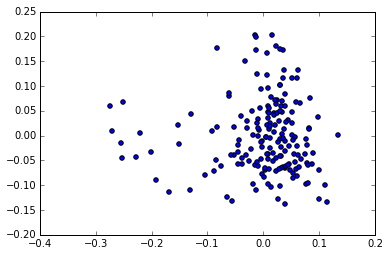

In [171]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=2)
data_2d = ica.fit_transform(scaled_data)
scatter(*(data_2d.T));

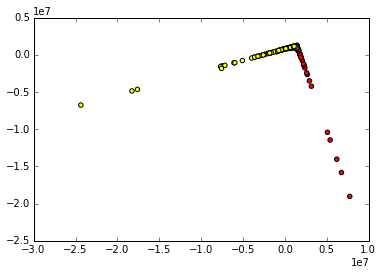

In [147]:
joint_idx = data_2d.argmax(axis=0)[1]
joint = data_2d[joint_idx]
branch_idx = (data_2d[:, 0] < joint[0])
scatter(*(data_2d.T), c=branch_idx);

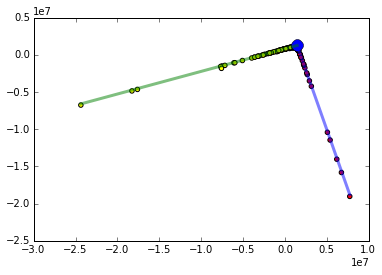

In [96]:
from sklearn.linear_model import LinearRegression
branches = [LinearRegression() for _ in [0, 1]]
scatter(*(data_2d.T), c=branch_idx);
plot(joint[0], joint[1], 'bo', markersize=12)
directions = []
for idx, branch in enumerate(branches):
    points = data_2d[branch_idx == idx]
    branch.fit(points[:, 0, np.newaxis], points[:, 1, np.newaxis])
    dx = (points[:, 0].max() - points[:, 0].min()) * [1, -1][idx]
    dy = branch.coef_ * dx
    directions.append(np.array((dx, dy), dtype=float))
    plot((joint[0], joint[0] + dx),
         (joint[1], joint[1] + dy),
         linewidth=3,
         alpha=0.5);

In [99]:
directions

[array([  6290814.7204772 , -20050770.97187498]),
 array([-25827404.94008032,  -7855792.5502958 ])]

In [100]:
initial_center = pca.inverse_transform(joint)
initial_directions = [pca.inverse_transform(i) for i in directions]

In [125]:
initial_directions

[array([  1705616.13070135,  21780065.57442008,     30426.32993618,
           120009.52858987,    362198.89296095]),
 array([  2.87761285e+07,   6.29836123e+05,  -1.85603967e+03,
          3.44091942e+03,  -9.36307422e+03])]

In [234]:
p = data.dropna().iloc[10]

In [235]:
p

a    547348
b     40330
c       425
d     45192
e       581
Name: 39, dtype: float64

In [128]:
def project(vector, direction):
    return vector.dot(direction) / direction.dot(direction)
def MSE(x, y):
    d = x - y
    return d.dot(d)
k = [project(p - initial_center, i) for i in initial_directions]

In [129]:
[(p - initial_center) / i for i in initial_directions]

[a    0.317095
 b    0.001749
 c   -0.031179
 d   -0.004911
 e   -0.024269
 Name: 39, dtype: float64, a    0.018795
 b    0.060480
 c    0.511114
 d   -0.171273
 e    0.938815
 Name: 39, dtype: float64]

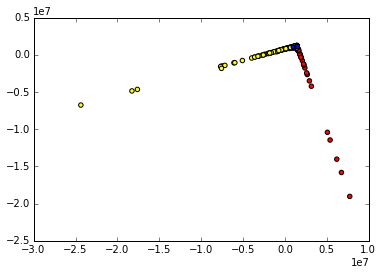

In [130]:
new_p = [(a * b + initial_center) for a, b in zip(k, initial_directions)]
scatter(*(data_2d.T), c=branch_idx);
scatter(*(pca.transform(new_p).T), marker="s");
scatter(*(pca.transform(p).T), marker="p");

In [131]:
p

a    547348
b     40330
c       425
d     45192
e       581
Name: 39, dtype: float64

In [132]:
new_p

[array([ 12753.82800104,  82019.14708105,   1485.10062975,  46220.93896424,
         10697.95119178]),
 array([ 547925.15430825,   14087.98753568,    1338.72635477,
          45846.07864913,    9195.03395029])]

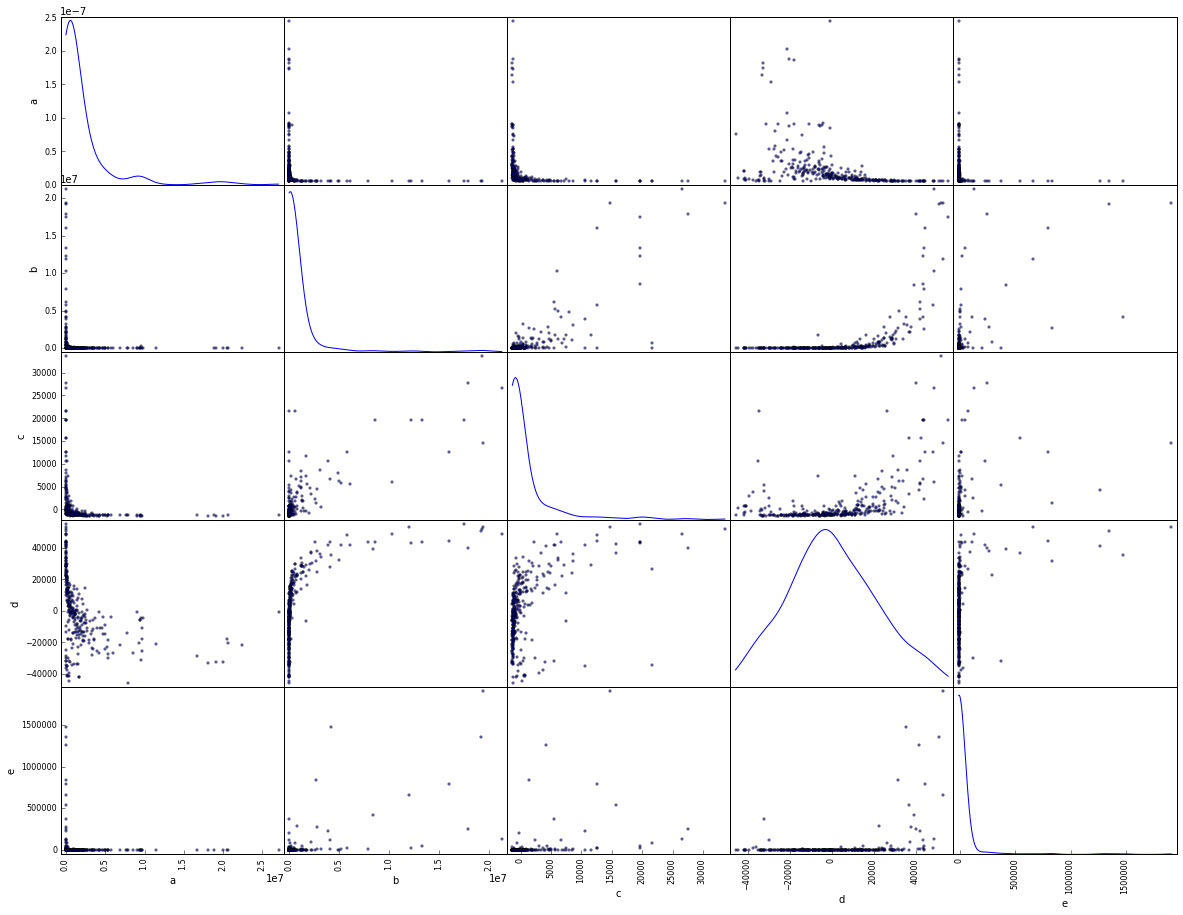

In [133]:
scatter_matrix(data - initial_center, figsize=(20, 15), diagonal='kde');

In [134]:
pca.components_

array([[ -9.55204997e-01,   2.95877296e-01,   5.33243525e-04,
          2.52354899e-03,   5.77804862e-03],
       [ -2.95939153e-01,  -9.55079792e-01,  -1.24276866e-03,
         -2.91240436e-03,  -1.52506487e-02]])

In [135]:
data.ix[~np.isnan(data.d)].describe()

,a,b,c,d,e
count,319.000000,345.000000,336.000000,404.000000,326.000000
mean,1927813.620690,928299.118841,2240.863095,46544.349010,37759.674847
std,3706390.875144,3066270.954140,4738.107406,21411.213027,189756.128372
min,444.000000,9.000000,0.000000,0.000000,1.000000
25%,104323.000000,7367.000000,137.500000,32090.250000,132.000000
50%,622070.000000,33046.000000,475.000000,44939.500000,802.000000
75%,1965439.500000,274050.000000,1850.000000,60289.250000,2528.000000
max,27057179.000000,21245399.000000,35000.000000,101295.000000,1918620.000000


In [136]:
data.ix[np.isnan(data.d)].describe()

,a,b,c,d,e
count,31.000000,30.000000,32.000000,0,31.000000
mean,1969663.548387,229303.633333,1635.000000,NaN,12816.322581
std,3767239.954894,887671.369678,3129.283129,NaN,40331.230109
min,7992.000000,27.000000,0.000000,NaN,4.000000
25%,324202.000000,3315.750000,107.500000,NaN,156.500000
50%,697847.000000,22107.000000,337.500000,NaN,661.000000
75%,1732257.500000,48330.750000,1150.000000,NaN,1817.500000
max,18896128.000000,4834455.000000,14000.000000,NaN,209374.000000
